In [ ]:
"""
Prediction file: Based on the trained neural network,see the performace on the testing set
Mapping Seed-> Sim (Fig 2)

General workflow
Load test data->Load trained dilResNet model and predict the output(are in latent representation) on test set-> 
Decode into higher dimensional representation using SD VAE-> Display 


"""

'\nPrediction file: Based on the trained neural network,see the performace on the training/validation set\nand also the testing set with predefined patterns and symbols. \n\nEDIT NOW ONLY SEEING PERFORMANCE ON TEST SET\nUPDATED ON 021024\nOn new patterns \n\n'

In [2]:
# import libraries 

import os
import torch
import torch.nn as nn
import cv2
import numpy as np
import matplotlib.pyplot as plt
from diffusers import AutoencoderKL
from PIL import Image
from skimage.metrics import structural_similarity as ssim



In [ ]:
# prediction from testing dataset

'''
Loading test data for model testing

'''

rfactor=256

img_length=rfactor
img_width=rfactor

# for CentOS 8 cluster 
datadir_i2='/hpc/group/youlab/ks723/storage/MATLAB_SIMS/Sim_050924/Sim_input/intermediate/Tp3'
datadir_o2="/hpc/group/youlab/ks723/storage/MATLAB_SIMS/Sim_050924/Sim_output"


datadir_i='/hpc/group/youlab/ks723/storage/MATLAB_SIMS/Sim_050924_ModelTesting/Sim_input/intermediate/Tp3'
datadir_o="/hpc/group/youlab/ks723/storage/MATLAB_SIMS/Sim_050924_ModelTesting/Sim_output"

path_i=os.path.join(datadir_i)
path_o=os.path.join(datadir_o)

path_i2=os.path.join(datadir_i2)
path_o2=os.path.join(datadir_o2)

ground_truth_data=[]
input_data=[]

# parameters for image

img_shape_i=256  # to make image 256x256 after cropping the image
img_shape_o=32   # to make image 32x32 after cropping the image 


# parameters for cropping output of sim hardcoded
top_crop_i = 30
bottom_crop_i = 30
left_crop_i = 31
right_crop_i = 30



# do training with the next 10k images. load previous training point 
def create_ground_truth_data(top_crop, bottom_crop, left_crop, right_crop, start_index, end_index,path_i):
    count = 0
    img_filenames_i = sorted(os.listdir(path_i))

    # Ensure end_index does not exceed the number of available images
    end_index = min(end_index, len(img_filenames_i))

    for img in img_filenames_i[start_index:end_index]:
        img_array_i = cv2.imread(os.path.join(path_i, img), cv2.IMREAD_GRAYSCALE)

        new_height = img_array_i.shape[0] - (top_crop + bottom_crop)
        new_width = img_array_i.shape[1] - (left_crop + right_crop)

        new_array_i = img_array_i[top_crop:top_crop + new_height, left_crop:left_crop + new_width]

        new_array_i = cv2.resize(new_array_i, (img_length, img_width))

        ground_truth_data.append([new_array_i])
        count = count + 1
        if count >= (end_index - start_index):
            break


start_index = 0  
end_index = 8   
create_ground_truth_data(top_crop_i, bottom_crop_i, left_crop_i, right_crop_i, start_index, end_index,path_i)


## add some of the images from the main dataset that hasn't been used to train the network 

start_index = 70000  
end_index = 70025 
create_ground_truth_data(top_crop_i, bottom_crop_i, left_crop_i, right_crop_i, start_index, end_index,path_i2)

top_crop_o=0
bottom_crop_o=0
left_crop_o=3
right_crop_o=2

def create_input_data(top_crop,bottom_crop,left_crop,right_crop, start_index, end_index,path_o):
    
    count=0

    img_filenames_o = sorted(os.listdir(path_o))
    # Ensure end_index does not exceed the number of available images
    end_index = min(end_index, len(img_filenames_o))
    
    for img in img_filenames_o[start_index:end_index]:
        img_array_o=cv2.imread(os.path.join(path_o,img),cv2.IMREAD_GRAYSCALE)

        new_height = img_array_o.shape[0] - (top_crop + bottom_crop)
        new_width = img_array_o.shape[1] - (left_crop + right_crop)
        new_array_o = img_array_o[top_crop:top_crop+new_height, left_crop:left_crop+new_width]

      
        (T, new_array_o) = cv2.threshold(new_array_o, 0, 255,cv2.THRESH_BINARY| cv2.THRESH_OTSU)

        input_data.append([new_array_o])
        count=count+1
        if count >= (end_index - start_index):
            break



start_index = 0  
end_index = 8   
create_input_data(top_crop_o, bottom_crop_o, left_crop_o, right_crop_o, start_index, end_index,path_o)


start_index = 70000  
end_index = 70025 
create_input_data(top_crop_o, bottom_crop_o, left_crop_o, right_crop_o, start_index, end_index,path_o2)



X=ground_truth_data  
y=input_data

X=(np.array(X).reshape(-1,1,img_shape_i,img_shape_i)) #/255.0  # last one is grayscale first minus one is all x
y=(np.array(y).reshape(-1,1,img_shape_o,img_shape_o)) #/255.0

# normalizing images here to be bw 0 and 1 

X=X/255.0 
y=y/255.0
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Convert numpy arrays to torch tensors
X = torch.Tensor(X)
y = torch.Tensor(y)


y3=y.repeat(1, 3, 1, 1)
y4=y.repeat(1, 4, 1, 1)


In [4]:
'''
Defining dilResNet model for loading model weights
'''
# Dilated Basic Block similar to PDEArena
class PDEArenaDilatedBlock(nn.Module):
    def __init__(self, in_planes, out_planes, dilation_rates, activation=nn.ReLU, norm=True):
        super(PDEArenaDilatedBlock, self).__init__()

        # Create dilated convolution layers with specified dilation rates
        self.dilated_layers = nn.ModuleList([
            nn.Conv2d(
                in_planes if i == 0 else out_planes, 
                out_planes, 
                kernel_size=3, 
                padding=rate, 
                dilation=rate, 
                bias=False
            )
            for i, rate in enumerate(dilation_rates)
        ])
        
        # Normalization and Activation layers
        self.norm_layers = nn.ModuleList([nn.BatchNorm2d(out_planes) if norm else nn.Identity() for _ in dilation_rates])
        self.activation = activation(inplace=True)

        # Shortcut (1x1 convolution if input and output planes differ)
        self.shortcut = nn.Sequential()
        if in_planes != out_planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, out_planes, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_planes) if norm else nn.Identity()
            )

    def forward(self, x):
        out = x
        for layer, norm in zip(self.dilated_layers, self.norm_layers):
            out = self.activation(norm(layer(out)))
        return out + self.shortcut(x)  # Residual connection

# Dilated ResNet with Adjustable Layers and Blocks
class PDEArenaDilatedResNet(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels=64, num_blocks=15, dilation_rates=[1, 2, 4, 8], activation=nn.ReLU, norm=True):
        super(PDEArenaDilatedResNet, self).__init__()
        
        self.in_conv = nn.Conv2d(in_channels, hidden_channels, kernel_size=3, padding=1)  # Input layer
        
        # Stack of dilated blocks
        self.layers = nn.Sequential(
            *[PDEArenaDilatedBlock(hidden_channels, hidden_channels, dilation_rates, activation=activation, norm=norm) for _ in range(num_blocks)]
        )
        
        self.out_conv = nn.Conv2d(hidden_channels, out_channels, kernel_size=3, padding=1)  # Output layer

    def forward(self, x):
        x = self.in_conv(x)
        x = self.layers(x)
        return self.out_conv(x)


model = PDEArenaDilatedResNet(
    in_channels=3,               # Input channels
    out_channels=4,              # Output channels 
    hidden_channels=64,          # Number of hidden channels
    num_blocks=15,               # Number of dilated blocks 
    dilation_rates=[1, 2, 4, 8], # Dilation rates for multi-scale feature capture
    activation=nn.ReLU,          # Activation function
    norm=True                    # Use BatchNorm after each convolution
)


/hpc/dctrl/ks723/miniconda3/envs/test_pytorch_ipy_v2/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


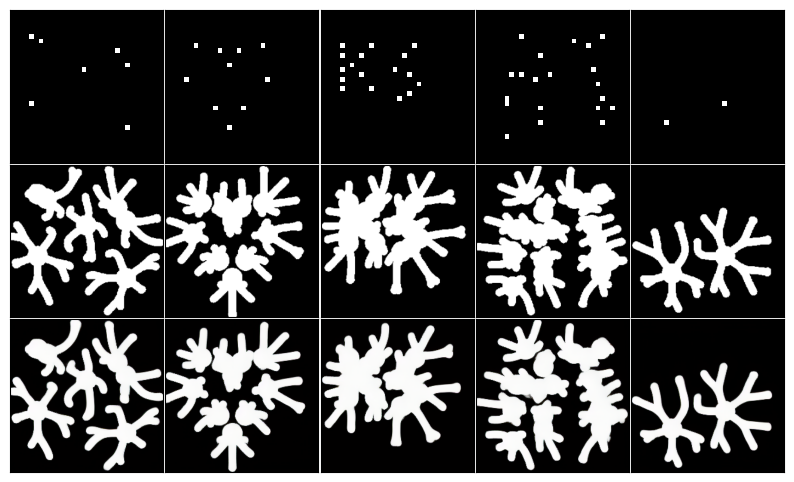

In [ ]:
'''
Define pre-trained SD VAE for decoding orginal predicted patterns from the latent predicted patterns
dilResnet will predict latent representation of patterns 

'''

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# first load the VAE

vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

vae.to(device)

def encode_img(input_img):
    input_img = input_img.repeat(3, 1, 1)
    
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    if len(input_img.shape)<4:
        input_img = input_img.unsqueeze(0)
    with torch.no_grad():
        latent = vae.encode(input_img*2 - 1) # Note scaling  # to make outputs from -1 to 1 
    return 0.18215 * latent.latent_dist.sample()    



def decode_img(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)    # to make outputs from 0 to 1 
    image = image.detach()
    return image



NAME='Pixel_32x32x3to32x32x4_dilRESNET_30k_newpatterns_seedtointermediate__Model_v1113_Cluster_GPU_tfData-1731542355'
model.load_state_dict(torch.load(f'/hpc/group/youlab/ks723/miniconda3/saved_models/trained/{NAME}.pt'))
model.to(device)

model.eval()
with torch.no_grad():
    predicted_latents=model(y3[:,:,:,:].to(device))  #y3 is the input seed with 3 channels for the UNET 


predicted_latents_rescaled=predicted_latents

# use the vae decoder to convert the encoded images to final patterns

pred_images=decode_img(predicted_latents_rescaled)


'''
Functions for displaying seed, actual simulation and predicted simulation
'''
# for generation see first row seed, second row final patterns(ground truth), third row generated patterns( predicted output)


def tensor_to_pil_v2(tensor):
    tensor = tensor.permute(1, 2, 0)  # Convert to (height, width, channels)
    img = (tensor.cpu().numpy() * 255).astype('uint8')
    return Image.fromarray(img.squeeze())

def display_predicted_images(input_seed,final_patterns,pred_images, num_samples):
   
    plt.figure(figsize=(6*num_samples/3,6))
    plt.subplots_adjust(wspace=0.01, hspace=0.01)

    for i in range(num_samples):

        image_i=tensor_to_pil_v2(input_seed[i,:,:,:])
        image_o=tensor_to_pil_v2(final_patterns[i,:,:,:])
        image_p= tensor_to_pil_v2(pred_images[i,:,:,:].to("cpu"))
        
        ax = plt.subplot(3, num_samples, i + 1)

        plt.imshow(image_i)
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(3, num_samples, i + 1+num_samples)

        plt.imshow(image_o)
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax=plt.subplot(3, num_samples, i + 1+ num_samples+ num_samples)

        plt.imshow(image_p,cmap="gray")
        
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        print(np.array(image_p).shape)
    
       

    plt.show()

selected_indices=[4,5,2,10,14] 
# Display samples from train dataset
display_predicted_images(y3[selected_indices,:,:,:],X[selected_indices,:,:,:], pred_images[selected_indices,:,:,:] ,len(selected_indices))   # 

In [6]:
'''
Functions for computing and displaying SSIM comparisions from predicted and actual images

'''

def compute_ssim_high_precision(original_images, reconstructed_images):
    ssim_values = []
    batch_size = original_images.shape[0]

    for i in range(batch_size):
        # Convert tensors to numpy arrays
        original = original_images[i].cpu().numpy()  # Shape: [channels, height, width]
        reconstructed = reconstructed_images[i].cpu().numpy()

        # Ensure images are in the range [0, 1]
        original = np.clip(original, 0, 1)
        reconstructed = np.clip(reconstructed, 0, 1)

        # Convert to [height, width, channels]
        original = np.transpose(original, (1, 2, 0))  # Shape: [height, width, channels]
        reconstructed = np.transpose(reconstructed, (1, 2, 0))

        # Convert reconstructed RGB image to grayscale using standard luminance formula
        if reconstructed.shape[2] == 3:
            reconstructed_gray = np.dot(reconstructed[..., :3], [0.2989, 0.5870, 0.1140])
        else:
            reconstructed_gray = reconstructed.squeeze(axis=2)

        # Ensure original image is grayscale
        if original.shape[2] == 1:
            original_gray = original.squeeze(axis=2)
        else:
            original_gray = np.dot(original[..., :3], [0.2989, 0.5870, 0.1140])

        # Compute SSIM
        ssim_index = ssim(original_gray, reconstructed_gray, data_range=1.0)
        ssim_values.append(ssim_index)

    return ssim_values


def display_images_with_ssim(reference_images, comparison_images, num_samples=3):
    # Compute SSIM values using high-precision data
    ssim_values = compute_ssim_high_precision(reference_images, comparison_images)

    fig, axes = plt.subplots(4, num_samples, figsize=(num_samples * 4, 16))
    fig.subplots_adjust(hspace=0.3, wspace=0.5)

    for i in range(num_samples):
        # Get the reference and comparison images
        ref_image = reference_images[i].cpu().numpy()  # Shape: [C, H, W] or [H, W]
        comp_image = comparison_images[i].cpu().numpy()  # Shape: [C, H, W]

        print(f"Sample {i}: ref_image.shape = {ref_image.shape}, comp_image.shape = {comp_image.shape}")

        # Handle the reference image (ground truth)
        if ref_image.ndim == 3 and ref_image.shape[0] == 1:
            # Grayscale image, squeeze the channel dimension
            ref_image_disp = ref_image.squeeze(0)  # Shape: [H, W]
        elif ref_image.ndim == 3:
            # If the image has more channels, convert to grayscale
            ref_image_disp = np.transpose(ref_image, (1, 2, 0))
            ref_image_disp = np.dot(ref_image_disp[..., :3], [0.2989, 0.5870, 0.1140])
        elif ref_image.ndim == 2:
            # Already a 2D grayscale image
            ref_image_disp = ref_image  # Shape: [H, W]
        else:
            raise ValueError(f"Unexpected ref_image shape: {ref_image.shape}")

        # Handle the comparison image (predicted image)
        if comp_image.ndim == 3 and comp_image.shape[0] == 3:
            # Transpose to [H, W, C]
            comp_image_disp = np.transpose(comp_image, (1, 2, 0))
            # Convert RGB to grayscale
            comp_image_disp = np.dot(comp_image_disp[..., :3], [0.2989, 0.5870, 0.1140])
        elif comp_image.ndim == 3 and comp_image.shape[0] == 1:
            comp_image_disp = comp_image.squeeze(0)  # Shape: [H, W]
        elif comp_image.ndim == 2:
            comp_image_disp = comp_image  # Shape: [H, W]
        else:
            raise ValueError(f"Unexpected comp_image shape: {comp_image.shape}")

        # Triplicate the single-channel array along the third dimension
        
        image_o=tensor_to_pil_v2(reference_images[i,:,:,:])
        image_p= tensor_to_pil_v2(comparison_images[i,:,:,:].to("cpu"))


        # Triplicate the single-channel array along the third dimension
        image_o_3channel = np.stack([image_o] * 3, axis=-1)
      
        abs_error = np.abs(np.array(image_o_3channel, dtype=np.float32) - np.array(image_p, dtype=np.float32))
        abs_error_image = Image.fromarray(abs_error.astype(np.uint8))
        
        

        # Display the reference image
        axes[0, i].imshow(ref_image_disp, cmap='gray')
        axes[0, i].axis('off')
        # axes[0, i].set_title('Ground Truth')

        # Display the comparison image
        axes[1, i].imshow(comp_image_disp, cmap='gray')
        axes[1, i].axis('off')
        # axes[1, i].set_title('Predicted Image')


            # Display the comparison image
        axes[2, i].imshow(abs_error_image, cmap='gray')
        axes[2, i].axis('off')
        # axes[1, i].set_title('Predicted Image')


        # Display the SSIM score
        axes[3, i].text(0.5, 0.5, f'{ssim_values[i]:.3f}',
                        ha='center', va='center', fontsize=50)
        axes[3, i].axis('off')

    plt.tight_layout()
    plt.show()


Sample 0: ref_image.shape = (1, 256, 256), comp_image.shape = (3, 256, 256)
Sample 1: ref_image.shape = (1, 256, 256), comp_image.shape = (3, 256, 256)
Sample 2: ref_image.shape = (1, 256, 256), comp_image.shape = (3, 256, 256)
Sample 3: ref_image.shape = (1, 256, 256), comp_image.shape = (3, 256, 256)
Sample 4: ref_image.shape = (1, 256, 256), comp_image.shape = (3, 256, 256)


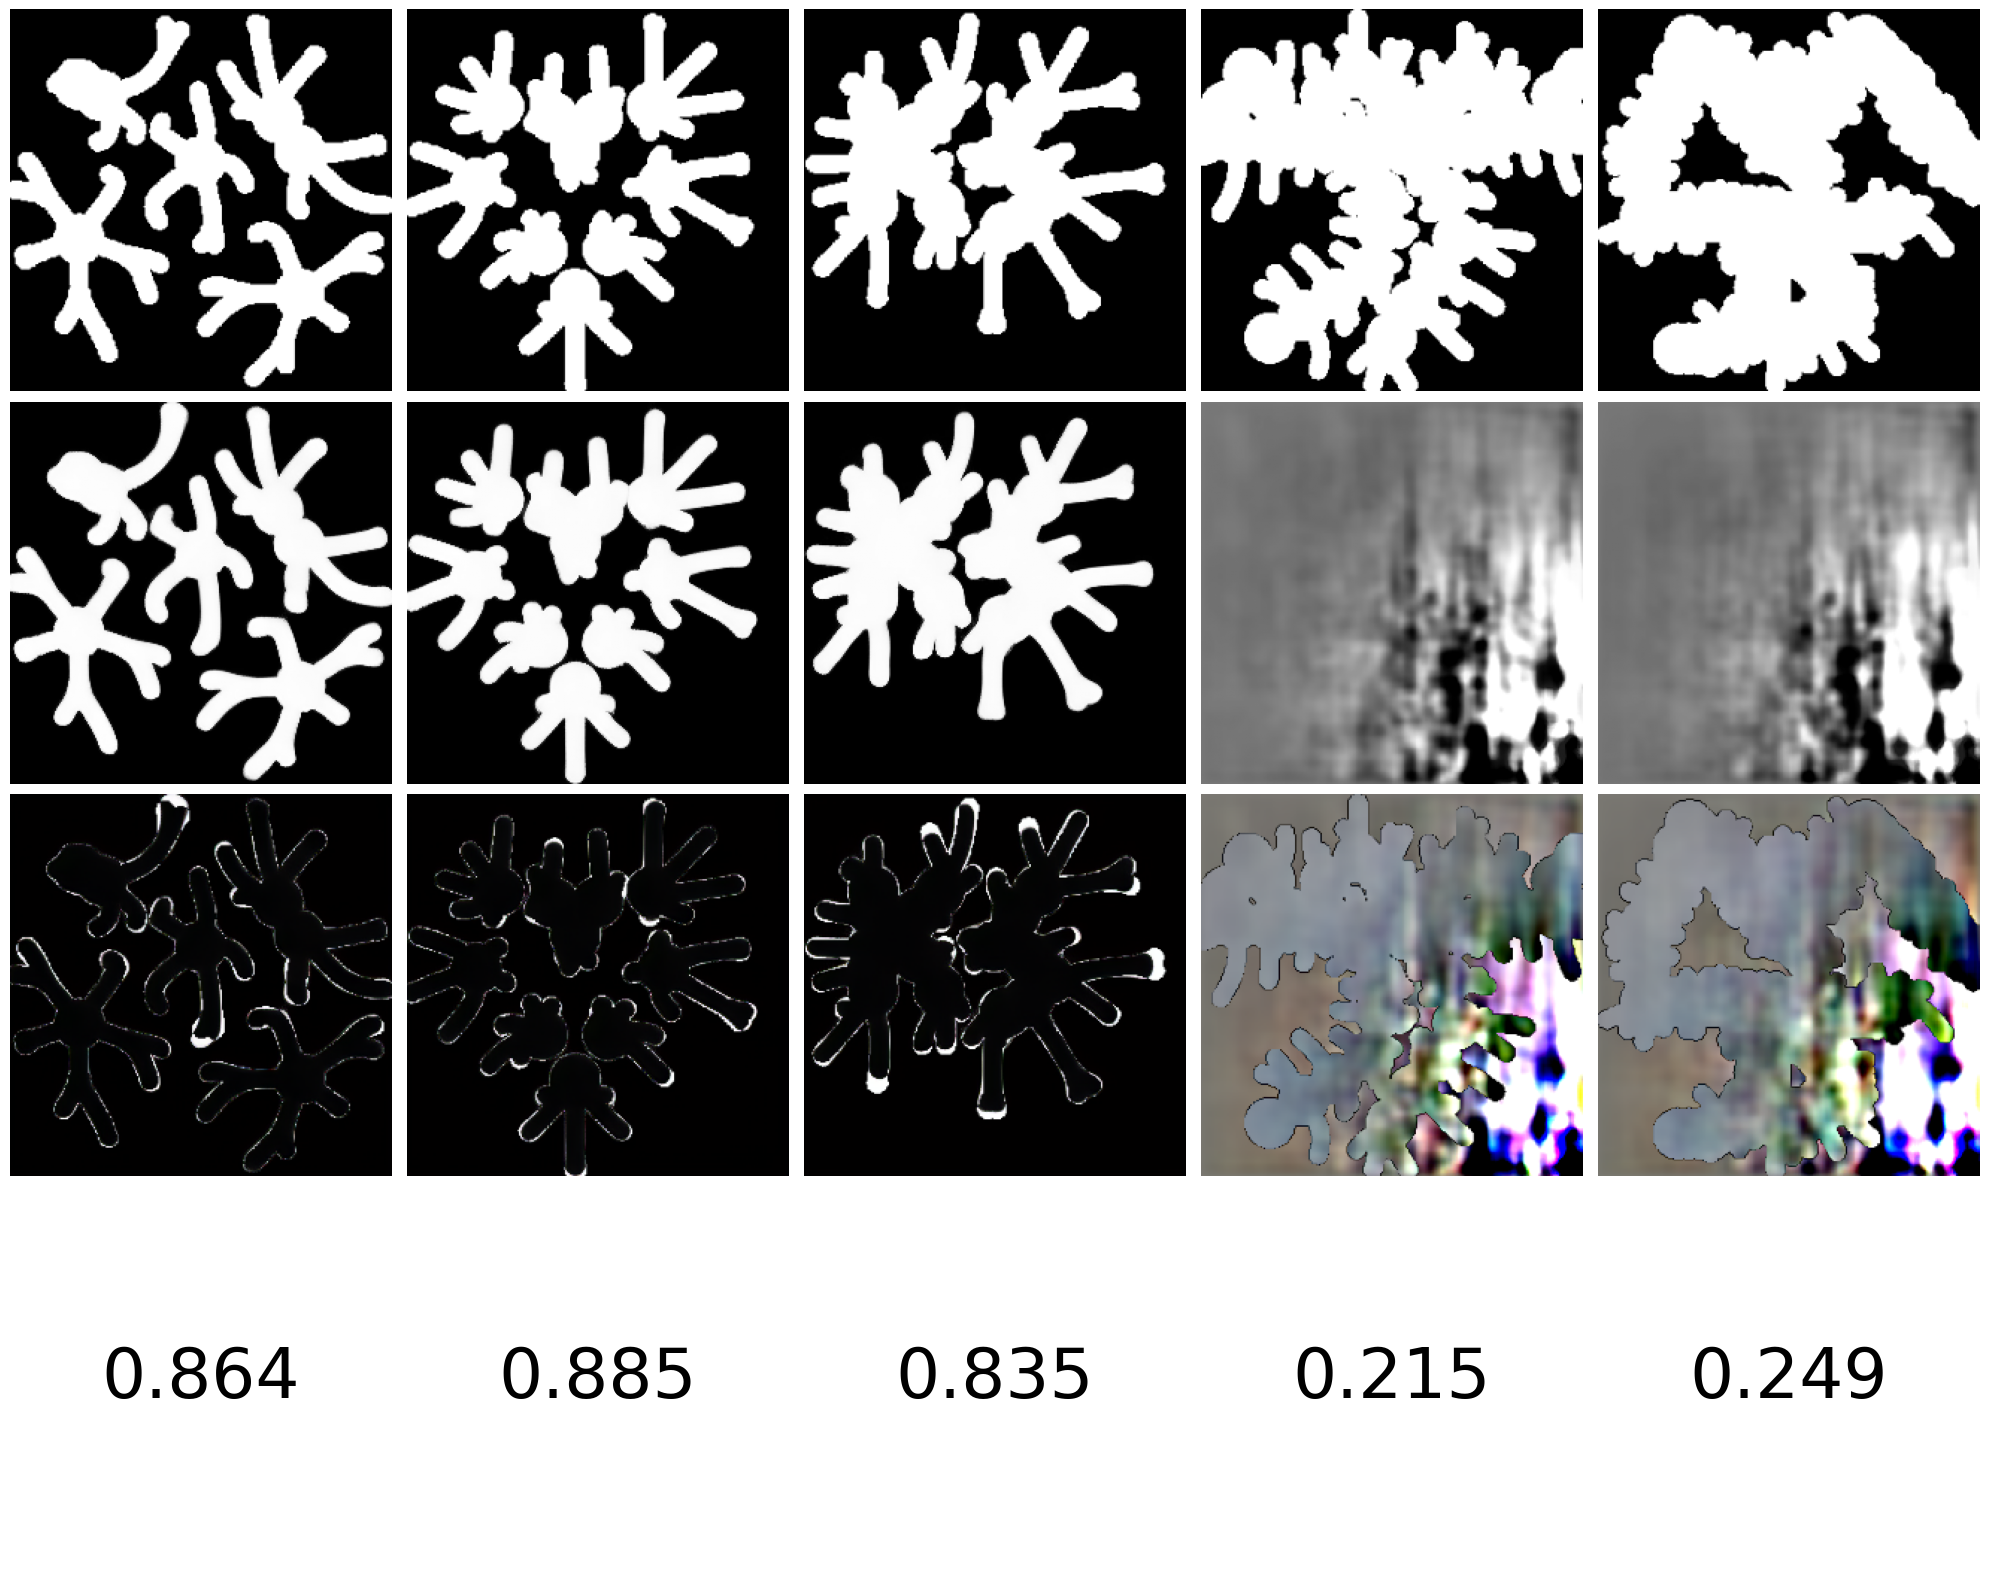

In [ ]:
'''
Results include images which have far more seeds than one used in training-> testing generalization and limitations
'''
selected_indices = [4, 5, 2, 6, 7] 

# Assuming X and pred_images are already defined
display_images_with_ssim(X[selected_indices], pred_images[selected_indices], num_samples=5)  #

Sample 0: ref_image.shape = (1, 256, 256), comp_image.shape = (3, 256, 256)
Sample 1: ref_image.shape = (1, 256, 256), comp_image.shape = (3, 256, 256)
Sample 2: ref_image.shape = (1, 256, 256), comp_image.shape = (3, 256, 256)
Sample 3: ref_image.shape = (1, 256, 256), comp_image.shape = (3, 256, 256)
Sample 4: ref_image.shape = (1, 256, 256), comp_image.shape = (3, 256, 256)


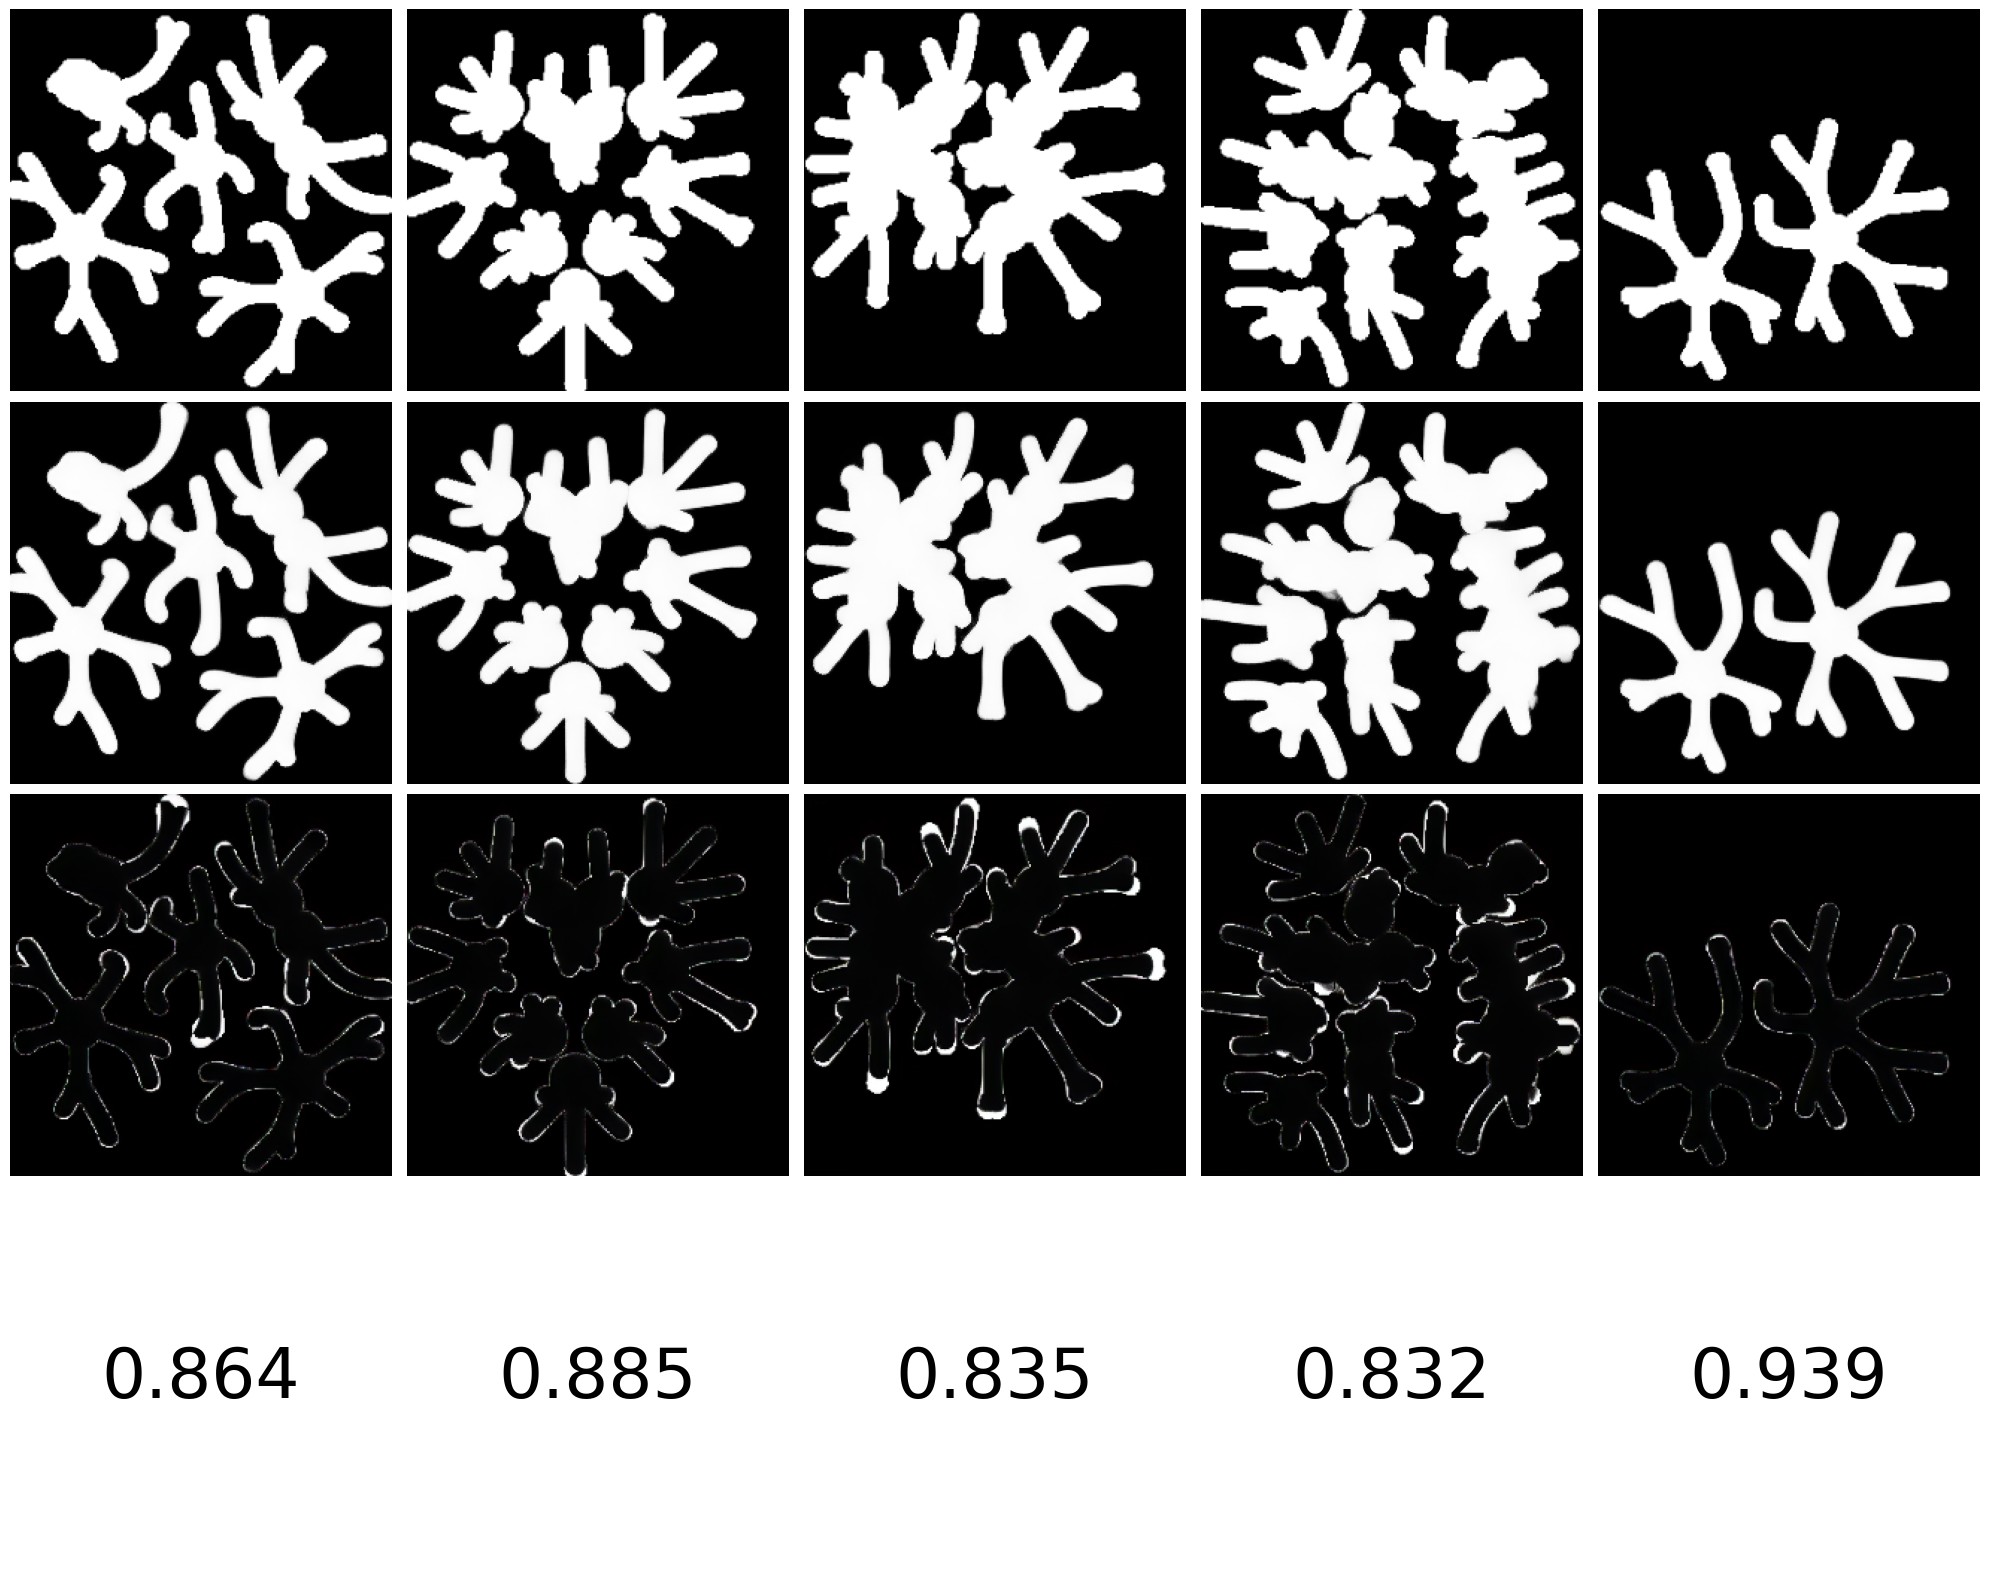

In [9]:
'''
Results represent images that have similar number of seeds as training set, but spatial positioning is different
'''
selected_indices = [4, 5, 2, 10, 14]

# Assuming X and pred_images are already defined
display_images_with_ssim(X[selected_indices], pred_images[selected_indices], num_samples=5)  #